<a href="https://colab.research.google.com/github/arahrooh31/UCLA_BE223C/blob/Keane_temp/DBT_patch_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import gc  #debug memory leaks in matplotlib
import csv #read in description files
import random #used to select random slice for patches
import cv2

from google.colab.patches import cv2_imshow
#
# Read Data from google drive
#
from google.colab import drive #for loading gdrive data
from google.colab import files

# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug
!pip3 install -q pickle5

import pydicom #to read dicom files
from pydicom import dcmread
import pickle5 as pickle; #generic storage of image arra

# Load data from google drive
#

drive.mount('/content/gdrive')

data_dir = '/content/gdrive/My Drive/DBT_DATA/IMG_ARRAYS'
top_dir = '/content/gdrive/My Drive/DBT_WORKSPACE/TRAINING_PATCHES' 

#output patch save dir
patch_normal_dir = '/content/gdrive/My Drive/DBT_WORKSPACE/TRAINING_PATCHES/NORMAL'
patch_actionable_dir = '/content/gdrive/My Drive/DBT_WORKSPACE/TRAINING_PATCHES/ACTIONABLE' 



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [85]:
def choose_tissue_area(img_data, patch_x,patch_y,slice_selection = 2,debug=0):


    if (debug == 1):  print('slice chosen is ',slice_selection)
    slice_data = img_data[slice_selection,:,:]

    # convert the grayscale image to binary image
    #look for anything >1 and assign that a 1 value. Expectation is that 
    #any area without attenuation will have 0 value -- adjust the lower val
    #if blurred areas need to be brought in. Last 0 is just the default
    #threshold type
    ret,thresh = cv2.threshold(slice_data,1,1,0)


    # calculate moments of binary image
    M = cv2.moments(thresh)
    # calculate x,y coordinate of center
    center_x = int(M["m10"] / M["m00"])
    center_y = int(M["m01"] / M["m00"])
    if (debug == 1):  print('center is ', center_x,center_y)


    # create a patch centered at the centroid location
    patch_lr = center_x-int(patch_x/2),center_x+int(patch_x/2)
    patch_tb = center_y-int(patch_y/2),center_y+int(patch_y/2)
    #        indices = np.where(slice_data!= [0])
    #        coordinates = zip(indices[0], indices[1])

    patch_img = img_data[slice_selection-1:slice_selection+2,patch_tb[0]:patch_tb[1],
                         patch_lr[0]:patch_lr[1]]


    if debug == 1:
        plt.figure()
        plt.imshow(thresh,cmap='bone') #img_data[slice_selection,:,:],cmap='bone')
        plt.text(center_x,center_y,'.')
        plt.text(patch_lr[0],patch_tb[0],'O')
        plt.colorbar()


        #### Draw annotation box
        xcorner = int(patch_lr[0])
        ycorner = int(patch_tb[0])
        xwidth = int(244)
        yheight = int(244)

        rect = patches.Rectangle((xcorner,ycorner),xwidth,yheight,linewidth=2,edgecolor='r',facecolor='none')
        # Get the current reference
        ax = plt.gca()
        # Add the patch to the Axes
        ax.add_patch(rect)
        plt.show()


    return patch_img,center_x,center_y


In [ ]:
#
# GENERATE SAMPLE PATCHES FOR NORMAL DATA
#

raw_files = os.listdir(data_dir)
print('found #files: ',len(raw_files))

patch_x = 244
patch_y = 244
for counter,filename in enumerate(raw_files):
    #load full array
    full_filename = os.path.join(data_dir,filename)
    if (('Normal' in filename) or ('Actionable' in filename)): 
        #only want to run on normal/actionable labels   
        img_data = pickle.load( open( full_filename, "rb" ) )
    else:
        print('SKIPPING non-Normal file')
        continue

    #get a random slice
    number_slices = np.shape(img_data)[0]
    #don't allow edge slices to be chosen
    slice_selection = random.randint(1, number_slices-1)

    patch_img,cx,cy = choose_tissue_area(img_data, patch_x,patch_y,
                                   slice_selection = slice_selection,
                                   debug=0)
    
    #save patch to a file
    output_fn = os.path.splitext(filename)[0]+'_cx' + str(cx) + '_cy' + \
    str(cy) + '_' + str(patch_x) + '_' + str(patch_y) + '.pickle'

    if ('Normal' in filename):
        img_file_pickle = os.path.join(patch_normal_dir,output_fn)
        pickle.dump(patch_img, open( img_file_pickle, "wb" ),protocol=5 )
    elif ('Actionable' in filename):
        img_file_pickle = os.path.join(patch_actionable_dir,output_fn)
        pickle.dump(patch_img, open( img_file_pickle, "wb" ),protocol=5 )
    else:
        #how did you get here??
        print('!!!!! Non-Normal/Actionable passed through!!!!!!')


    if (counter%200==0):
        print('shape of return is ', counter, np.shape(patch_img))
        plt.figure()
        plt.imshow(patch_img[1,:,:])
        plt.colorbar()

    del patch_img
    del img_data
    #else:
    #    break



found #files:  2568
shape of return is  0 (3, 244, 244)
SKIPPING non-Normal file
SKIPPING non-Normal file
SKIPPING non-Normal file
SKIPPING non-Normal file
SKIPPING non-Normal file
SKIPPING non-Normal file
SKIPPING non-Normal file
SKIPPING non-Normal file
SKIPPING non-Normal file
SKIPPING non-Normal file
SKIPPING non-Normal file
SKIPPING non-Normal file


found #files:  2568
slice chosen is  58
center is  1264 1243


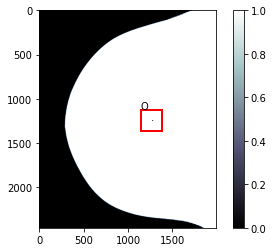

In [54]:
#
# Choose valid patch size for Normal images
#

raw_files = os.listdir(data_dir)
print('found #files: ',len(raw_files))

if (1):
    #create fake patches for now
    patch_dict = {}
    for counter,filename in enumerate(raw_files):
        #load full array
        full_filename = os.path.join(data_dir,filename)
        img_data = pickle.load( open( full_filename, "rb" ) )

        #get a random slice
        number_slices = np.shape(img_data)[0]
        slice_selection = random.randint(0, number_slices-1)
        print('slice chosen is ',slice_selection)
        slice_data = img_data[slice_selection,:,:]

        # convert the grayscale image to binary image
        #look for anything >1 and assign that a 1 value. Expectation is that 
        #any area without attenuation will have 0 value -- adjust the lower val
        #if blurred areas need to be brought in. Last 0 is just the default
        #threshold type
        ret,thresh = cv2.threshold(slice_data,1,1,0)

        
        # calculate moments of binary image
        M = cv2.moments(thresh)
        # calculate x,y coordinate of center
        center_x = int(M["m10"] / M["m00"])
        center_y = int(M["m01"] / M["m00"])
        print('center is ', center_x,center_y)

        patch_x = 244
        patch_y = 244
        # create a patch centered at the centroid location
        patch_lr = center_x-int(patch_x/2),center_x+int(patch_x/2)
        patch_tb = center_y-int(patch_y/2),center_y+int(patch_y/2)
#        indices = np.where(slice_data!= [0])
#        coordinates = zip(indices[0], indices[1])


        plt.figure()
        plt.imshow(thresh,cmap='bone') #img_data[slice_selection,:,:],cmap='bone')
        plt.text(center_x,center_y,'.')
        plt.text(patch_lr[0],patch_tb[0],'O')
        plt.colorbar()


        #### Draw annotation box
        xcorner = int(patch_lr[0])
        ycorner = int(patch_tb[0])
        xwidth = int(244)
        yheight = int(244)
        
        rect = patches.Rectangle((xcorner,ycorner),xwidth,yheight,linewidth=2,edgecolor='r',facecolor='none')
        # Get the current reference
        ax = plt.gca()
        # Add the patch to the Axes
        ax.add_patch(rect)
        plt.show()
        ###



        #patch_data = img_data[0:3,:,:]
        #patch_dict[counter]= patch_data
        #print(full_filename,np.shape(patch_data))



        if (counter >= 0):
            break


In [26]:
iter(coordinates,3)

TypeError: ignored